In [ ]:
import numpy as np
import pandas as pd
from pandas_datareader import data as pdr

import seaborn as sns

import statsmodels.api as sm
import statsmodels.formula.api as smf

In [ ]:
pip install yfinance

In [ ]:
from pandas_datareader import data as pdr
import yfinance as yfin
yfin.pdr_override()
#ANAの株価を取得
df_ana = pdr.get_data_yahoo("9202.T", start="2013-01-01", end="2021-12-31", interval="1mo")
#ケロシン（燃料）の価格を取り込む
df_fuels = pd.read_csv("kerosene.csv")
df_nikkei = pdr.get_data_yahoo("^N225", start="2013-01-01", end="2021-12-31", interval="1mo")

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [ ]:
#df_jal = pdr.get_data_yahoo("9201.T", start="2013-01-01", end="2021-12-31", interval="1mo")
#df_exchange = pd.read_csv("JPY=X.csv") #https://finance.yahoo.com/quote/JPY%3DX/history?period1=1325376000&period2=1672444800&interval=1d&filter=history&frequency=1d&includeAdjustedClose=true

In [ ]:
df = pd.DataFrame()

df["ANA"] = df_ana["Close"]
#df["JAL"] = df_jal["Close"]
#df["DY"] = df_exchange["Close"].tolist()
df["Kerosene"] = df_fuels["Price"].tolist()
df["Nikkei"] = df_nikkei["Close"]

df

,ANA,Kerosene,Nikkei
Date,,,
2013-01-01,1790.0,3.334,11138.660156
2013-02-01,1900.0,3.474,11559.360352
2013-03-01,1920.0,3.137,12397.910156
2013-04-01,2120.0,2.889,13860.860352
2013-05-01,2130.0,2.793,13774.540039
...,...,...,...
2021-08-01,2605.5,1.899,28089.539062
2021-09-01,2905.5,2.109,29452.660156
2021-10-01,2653.0,2.434,28892.689453


<Axes: >

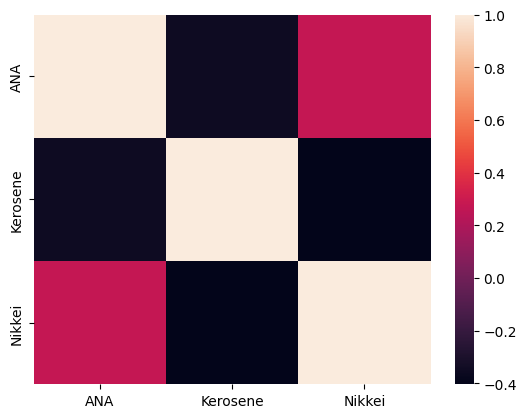

In [ ]:
sns.heatmap(df.corr())
#円安になる程ANA株高
#燃料高になる程ややANA株安
#日経平均ともある程度正の相関関係

In [ ]:
#logを取って分析することもできる（記事では使用していない）
def makelog(df):
  datalog = {}
  datalog["Date"] = df["Date"]
  for i in df.columns.drop("Date"):
    log = (np.log(df[i])) * 100
    datalog["log_" + i] = log
  return pd.DataFrame(datalog)
df.columns

Index(['ANA', 'Kerosene', 'Nikkei'], dtype='object')

In [ ]:
#dflog = makelog(df)
#dflog

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


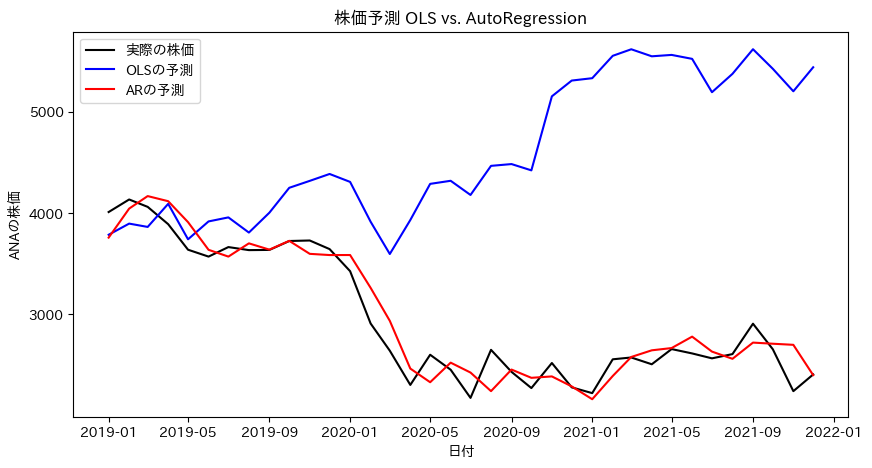

In [184]:
test_months = 36 #最後の36ヶ月（3年）分をテストデータにする

x = df.drop(["ANA"], axis = 1) #ANAの株価以外の要素をx（独立変数）とする
y = df["ANA"] #ANAの株価をy（従属変数）とする

#学習データ
x_train = x[:len(df) - test_months]
y_train = y[:len(df) - test_months]

#テストデータ
x_test = x[len(df) - test_months:]
y_test = y[len(df) - test_months:]

X_train = sm.add_constant(x_train)

model = sm.OLS(y_train, X_train).fit(cov_type="HC1") #モデルを学習させる



X_test = sm.add_constant(x_test)
pred_OLS= model.predict(X_test) #予測

from statsmodels.tsa.ar_model import AutoReg

#run auto regressive model in lags 24
ar_model=AutoReg(df['ANA'], lags=24).fit()

pred_AR = ar_model.predict(start=len(x_train), end=(len(df) - 1), dynamic=False)

plt.figure(figsize=(10,5))

actual_line, = plt.plot(y_test, color="black")
ols_line, = plt.plot(pred_OLS, color="blue")
ar_line, = plt.plot(pred_AR, color="red")
plt.title('株価予測 OLS vs. AutoRegression')
plt.legend([actual_line, ols_line, ar_line], ['実際の株価', 'OLSの予測', 'ARの予測'])

plt.xlabel('日付')
plt.ylabel('ANAの株価')

plt.yticks([3000, 4000, 5000])

plt.show()

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/deterministic.py:302: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Index with a unit increment support extending. The index is set will contain the position relative to the data length.
  fcast_index = self._extend_index(index, steps, forecast_index)


                            AutoReg Model Results                             
Dep. Variable:                    ANA   No. Observations:                  108
Model:                    AutoReg(24)   Log Likelihood                -554.821
Method:               Conditional MLE   S.D. of innovations            178.766
Date:                Sat, 05 Aug 2023   AIC                           1161.642
Time:                        04:10:26   BIC                           1224.844
Sample:                    01-01-2015   HQIC                          1187.049
                         - 12-01-2021                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        204.4503    152.255      1.343      0.179     -93.964     502.865
ANA.L1         0.8379      0.107      7.835      0.000       0.628       1.048
ANA.L2         0.1915      0.144      1.331      0.1

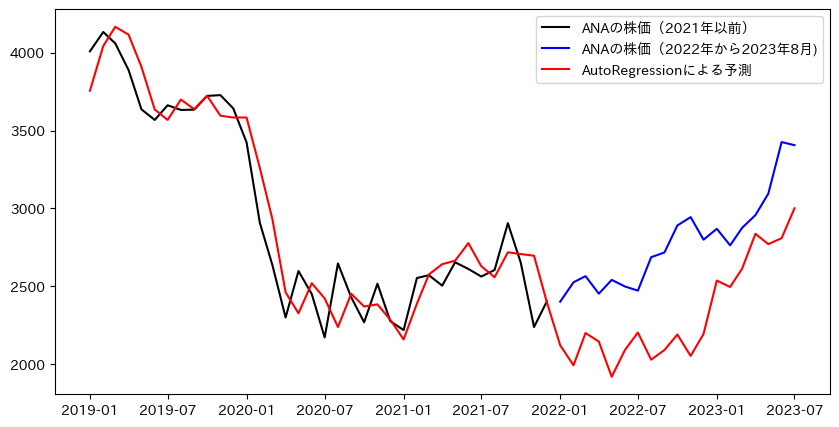

In [185]:
from statsmodels.tsa.ar_model import AutoReg

#run auto regressive model in lags 24
ar_model=AutoReg(df['ANA'], lags=24).fit()

print(ar_model.summary())

from statsmodels.graphics.tsaplots import plot_pacf
#pacf = plot_pacf(df['ANA'], lags=24)

#train_data=dflog['log_gdp'][:len(df)-50]
#test_data=dflog['log_gdp'][len(df)-50:]

plt.figure(figsize=(10,5))

#2023年8月まで予測
pred_AR = ar_model.predict(start=len(x_train), end=(len(df) + 18), dynamic=False)

ana_recent = pdr.get_data_yahoo("9202.T", start="2022-01-01", end="2023-08-01", interval="1mo")

old_actual, = plt.plot(y_test, color="black")
new_actual, = plt.plot(ana_recent["Close"], color="blue")
ar_line, = plt.plot(pred_AR, color="red")

plt.legend([old_actual, new_actual, ar_line], ["ANAの株価（2021年以前）", "ANAの株価（2022年から2023年8月)", "AutoRegressionによる予測"])


#plot(y_test, ana_recent["Close"])

from sklearn.metrics import mean_absolute_error
print("OLSの平均した誤差: ", mean_absolute_error(y_test, pred_OLS))
#print("ARの平均した誤差: ", mean_absolute_error(y_test, pred_AR))